In [1]:
import os

if "script" in os.getcwd():
    os.chdir("..")
os.getcwd()
import warnings

warnings.filterwarnings("ignore")

import torch
import numpy as np
from src.logger.logger import configure_logging
from src.model.utils import get_model

import glob
import torchvision
import random
import cv2
import matplotlib.pyplot as plt
from loguru import logger

from torchvision import transforms


torch.manual_seed(1234)
np.random.seed(1234)

# logger = configure_logging()

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Device : {device}")

from torch.nn.functional import mse_loss


def read_npy(path: str):
    with open(path, "rb") as f:
        a = np.load(f)
        a = a / np.max(a) * 255
    return a


def show_im(im, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    if isinstance(im, list):
        plt.imshow(np.hstack([i for i in im]), cmap="gray")
    else:
        plt.imshow(im, cmap="gray")
    plt.show()


def show_multi_im(imgs: list, ratio=(5, 12), figsize=(20, 10)):
    index = 0
    f, axarr = plt.subplots(ratio[0], ratio[1], figsize=figsize)
    for r in range(ratio[0]):
        for c in range(ratio[1]):

            axarr[r, c].imshow(imgs[index], cmap="gray")
            index += 1
    plt.show()

2023-03-01 00:28:49.693 | INFO     | __main__:<cell line: 31>:31 - Device : cuda:0


In [2]:
best_paths = ["dncnn_15.pth"]
best_path = best_paths[0]

dncnn_config = {
    "layers": 20,
    "channels": 1,
    "features": 192,
    "n_workers": 10,
    "scheduler_mode": min,
    "scheduler_patience": 1,
    "model_name": "Dncnn",
    "loss_function": "L2",
    "alpha_loss": [0.001],
    "weight": os.path.join(r"result\dncnn_origin", best_path),
    "data_dir": "data",
}

In [4]:
from src.model.author_dncnn import DnCNN as net

model = net(in_nc=1, out_nc=1, nc=64, nb=17, act_mode="R")
model.load_state_dict(torch.load(dncnn_config["weight"]), strict=True)
model.eval()
for k, v in model.named_parameters():
    v.requires_grad = False
model = model.to(device)

transform = transforms.ToTensor()

# Test with Test Data

In [23]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd
import json

phase = "test"
sigma = 15
num_samples = 60

data = glob.glob(f"{dncnn_config['data_dir']}/{phase}/sigma_{sigma}/*.npy")
print(f"Number images of sigma {sigma}: {len(data)}")

clip = True
normalize = True


def get_infor(data, lib="torch"):
    lib = torch if lib == "torch" else np
    return f"Max: {lib.max(data)} - Min: {lib.min(data)}"


metric_table = pd.DataFrame(columns=["psnr_cnn10", "ssim_cnn10"])
columns = list(metric_table.keys())

for image_path in random.sample(data, num_samples):

    metric = {"psnr": {"resnet": 0, "cnn": 0}, "ssim": {"resnet": 0, "cnn": 0}}

    origin = read_npy(image_path.replace(f"sigma_{sigma}", "origin"))
    noised_im = read_npy(image_path)

    origin_tensor = transform(origin.astype(np.int32)).float()
    noised_im_tensor = transform(noised_im.astype(np.int32)).float()
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")

    if clip:
        origin_tensor = origin_tensor.clamp(0, 255)
        noised_im_tensor = noised_im_tensor.clamp(0, 255)

    if normalize:
        origin_tensor = origin_tensor.div(255)
        noised_im_tensor = noised_im_tensor.div(255)
    # logger.info('------------------After------------------')
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")
    dncnn_pred_noise = model(noised_im_tensor.cuda().unsqueeze(0))

    denoise_dncnn = dncnn_pred_noise

    if normalize:
        denoise_dncnn = denoise_dncnn * 255

    if clip:
        denoise_dncnn = denoise_dncnn.clamp(0, 255)

    denoise_dncnn = (
        denoise_dncnn.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    )

    metric["psnr"]["cnn"] = psnr(origin.astype(np.uint8), denoise_dncnn)

    metric["ssim"]["cnn"] = ssim(origin.astype(np.uint8), denoise_dncnn)
    row = {columns[0]: metric["psnr"]["cnn"], columns[1]: metric["ssim"]["cnn"]}
    metric_table = metric_table.append(row, ignore_index=True)
    # print(json.dumps(metric, sort_keys=True, indent=4))
    # show_im([origin.astype(np.uint8), noised_im.astype(np.uint8), denoise_dncnn])

# print(metric_table)
print(f"Average: {metric_table.mean()}")

Number images of sigma 15: 60
Average: psnr_cnn10    22.684645
ssim_cnn10     0.715055
dtype: float64


# Random test samples

Number images of sigma 15: 60


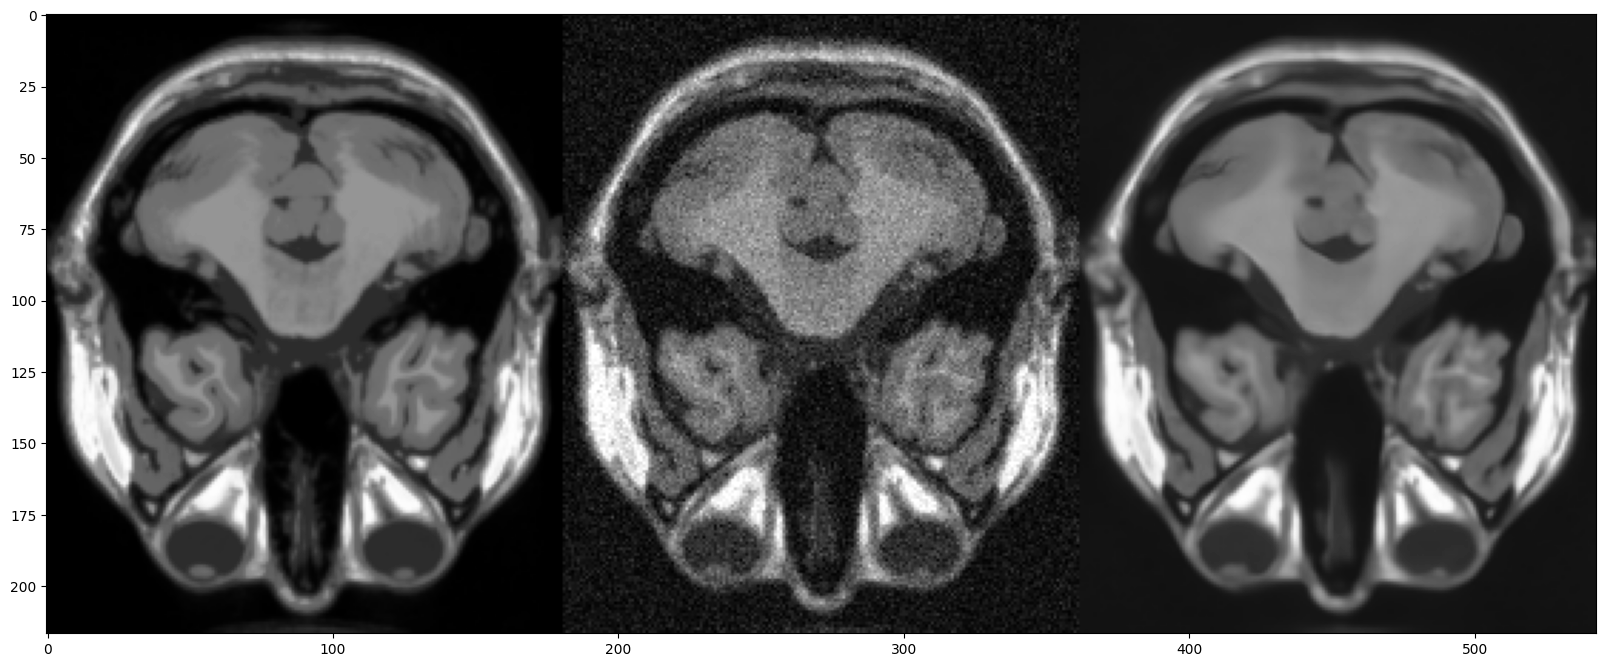

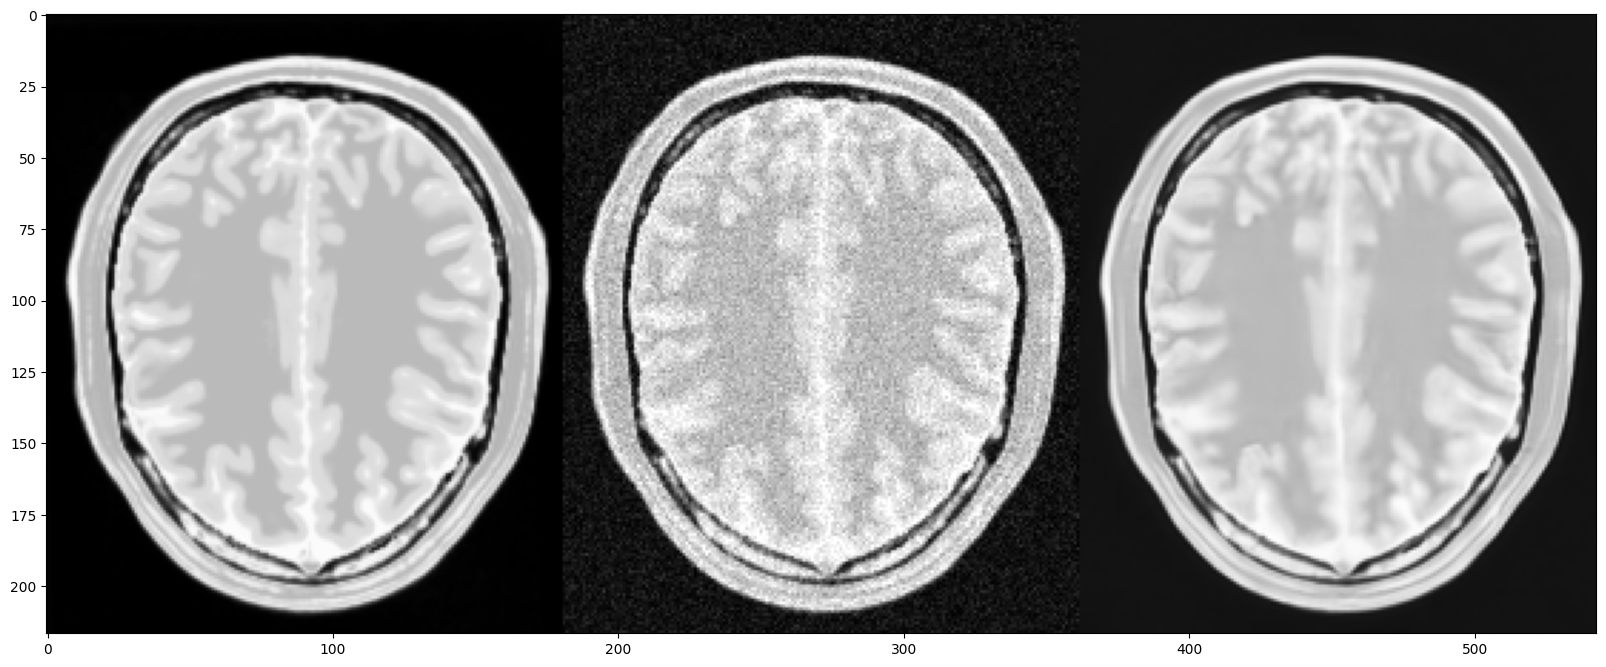

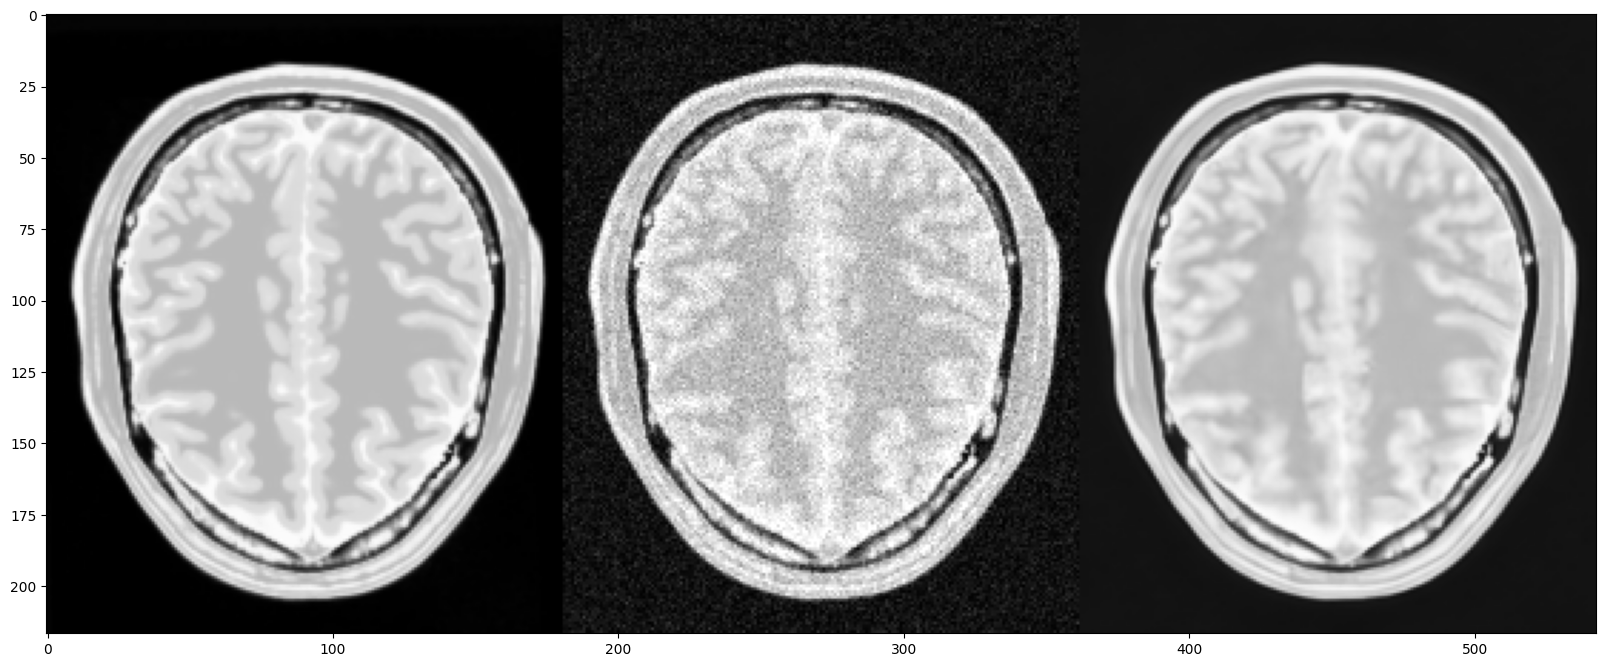

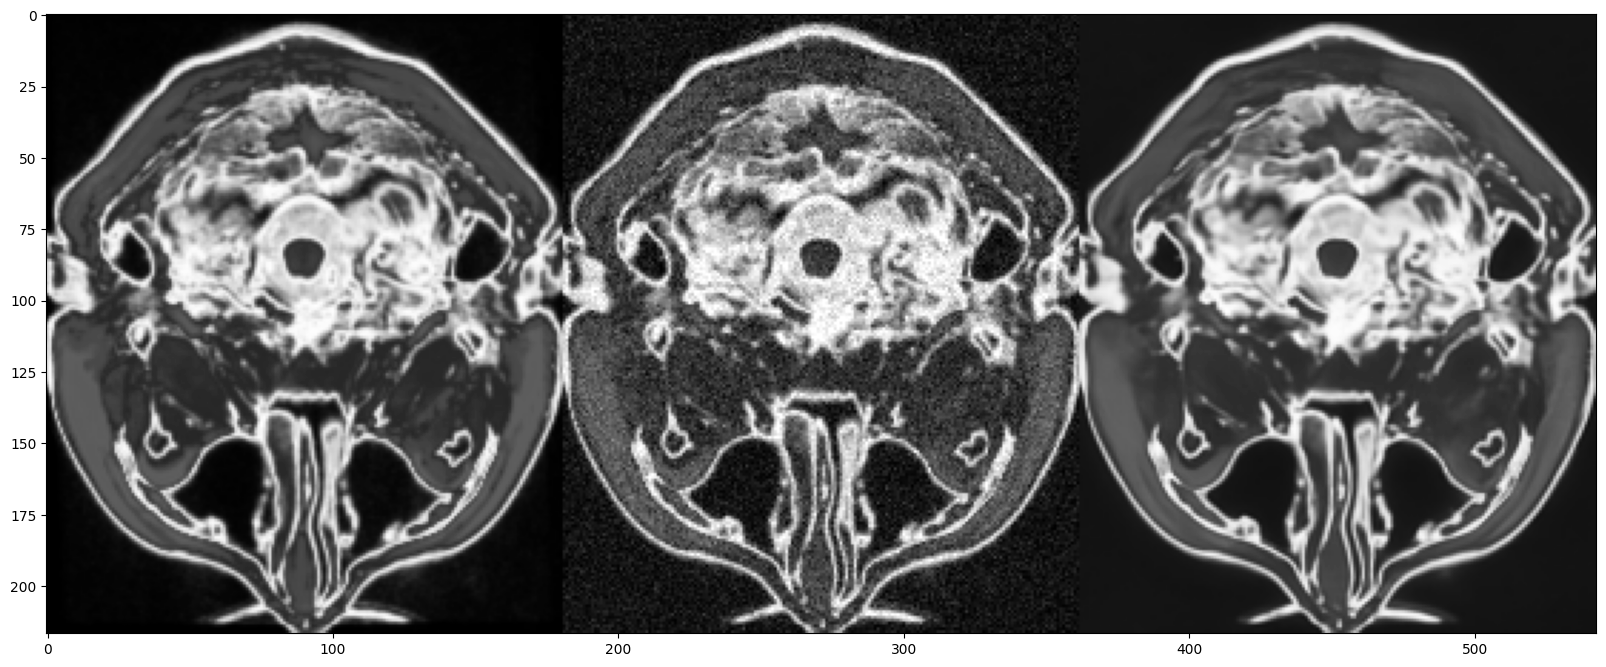

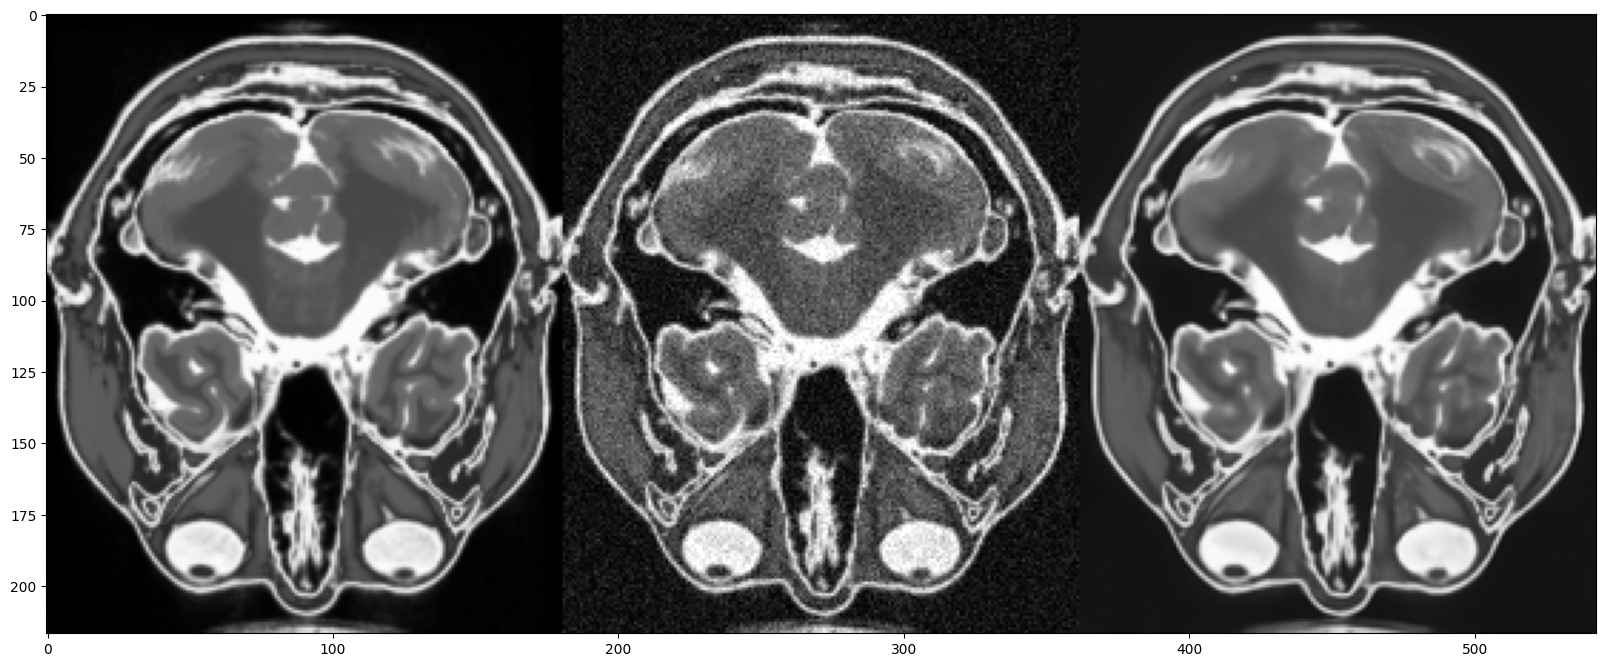

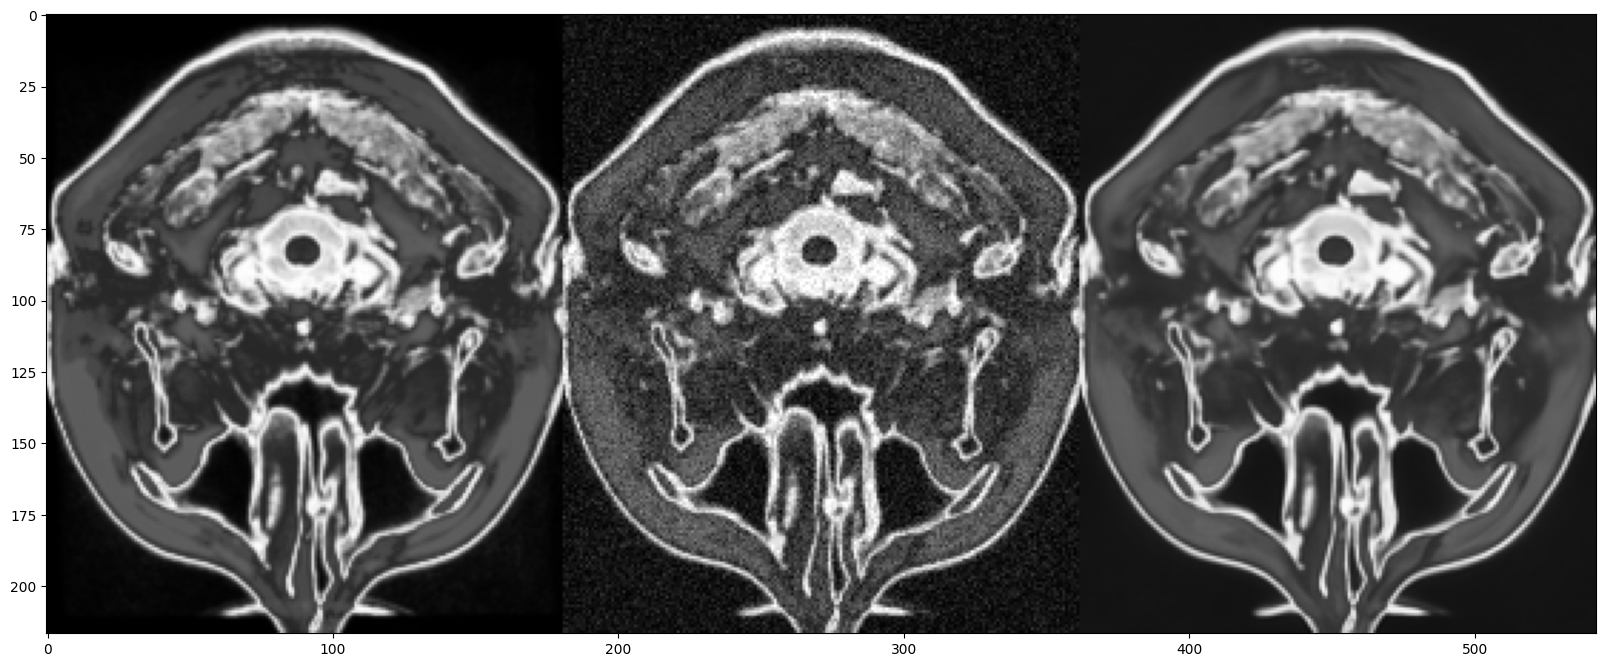

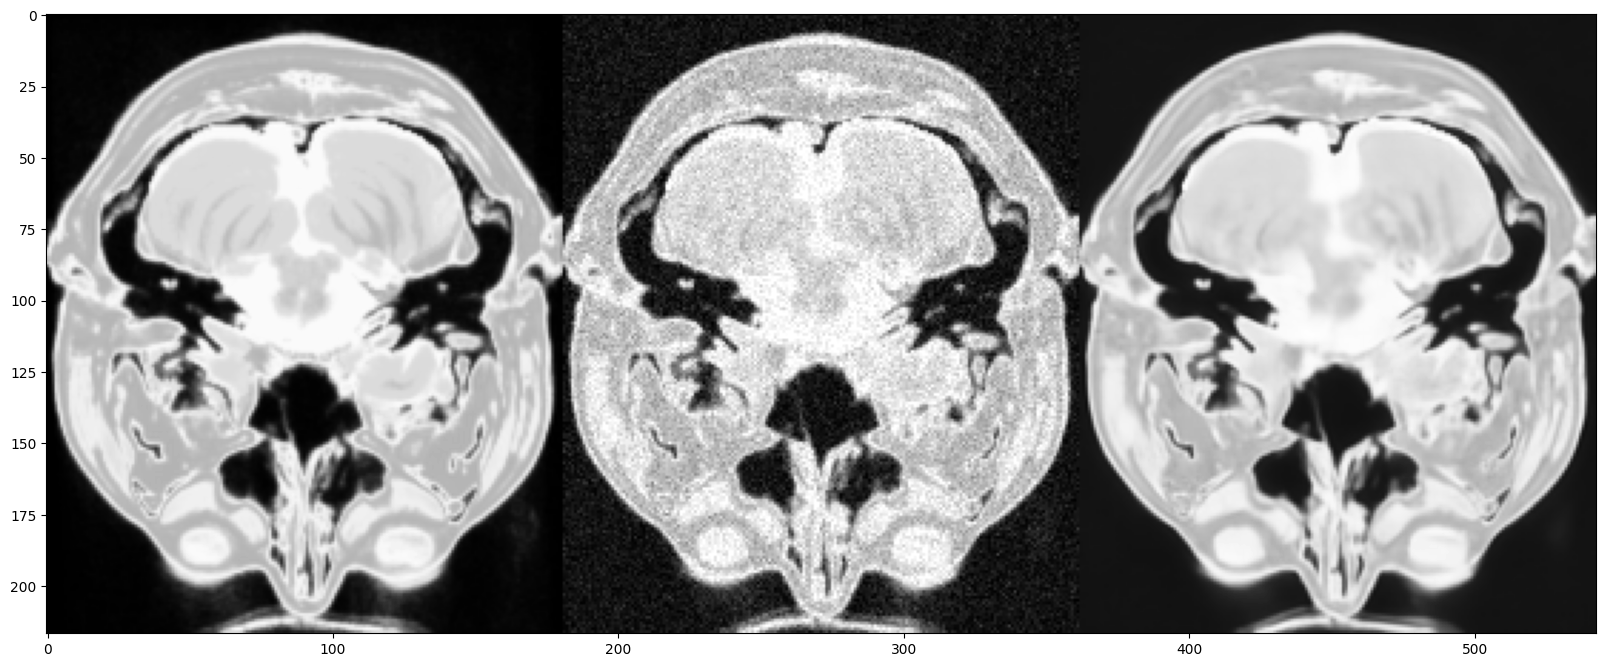

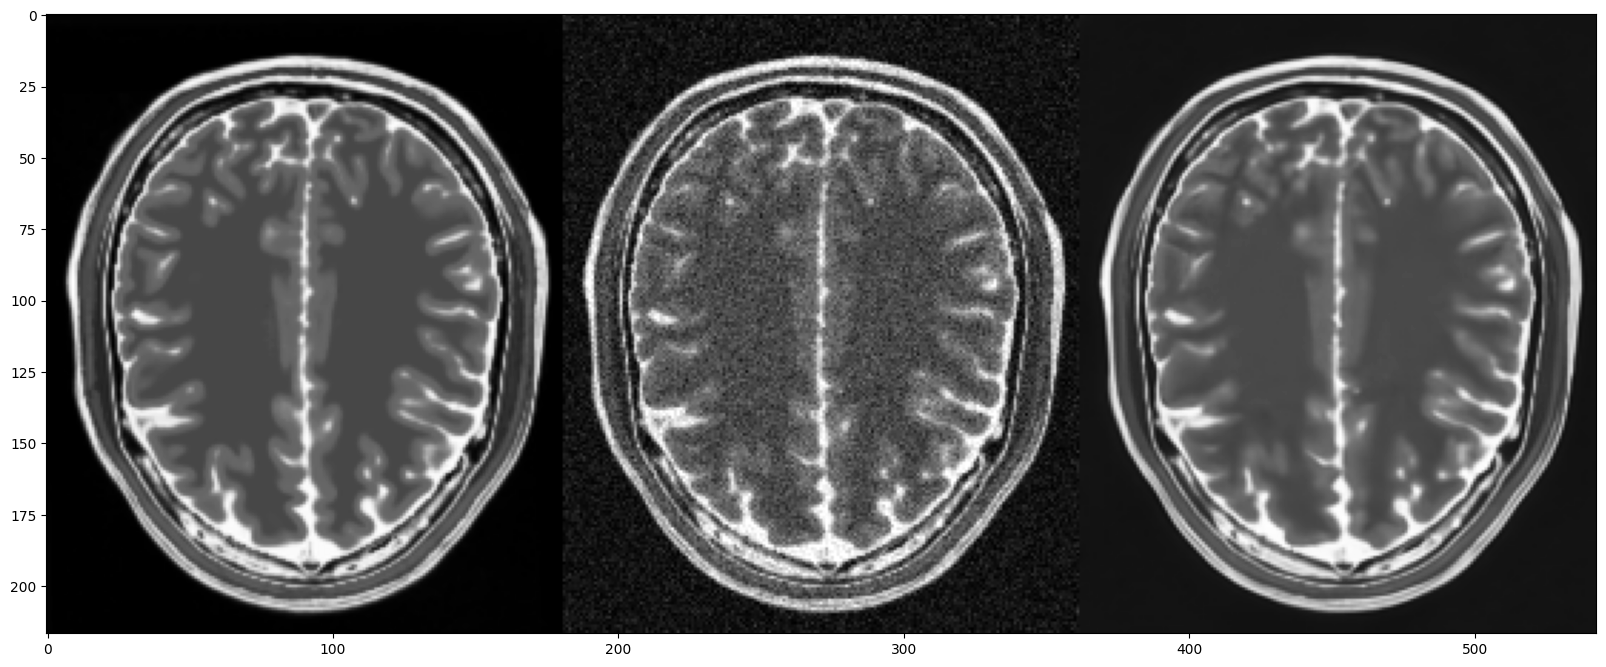

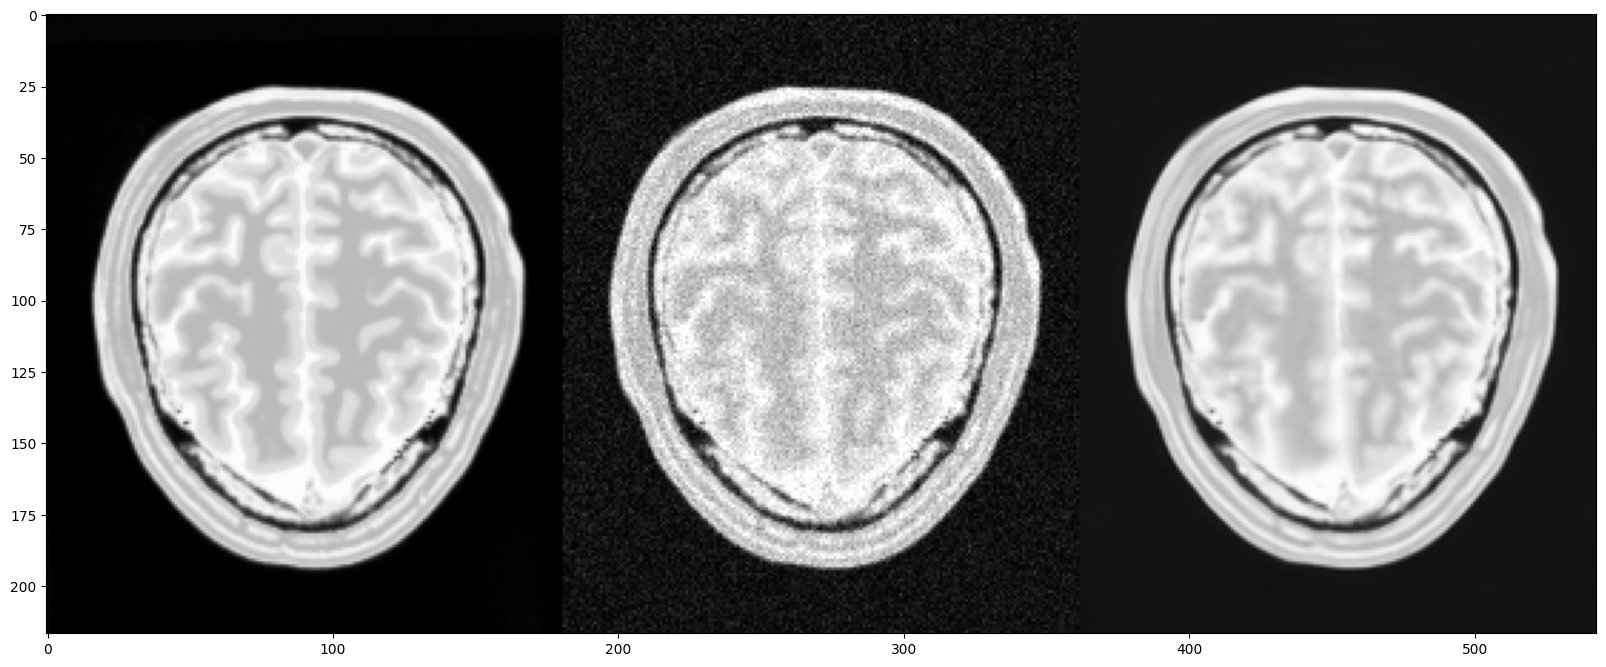

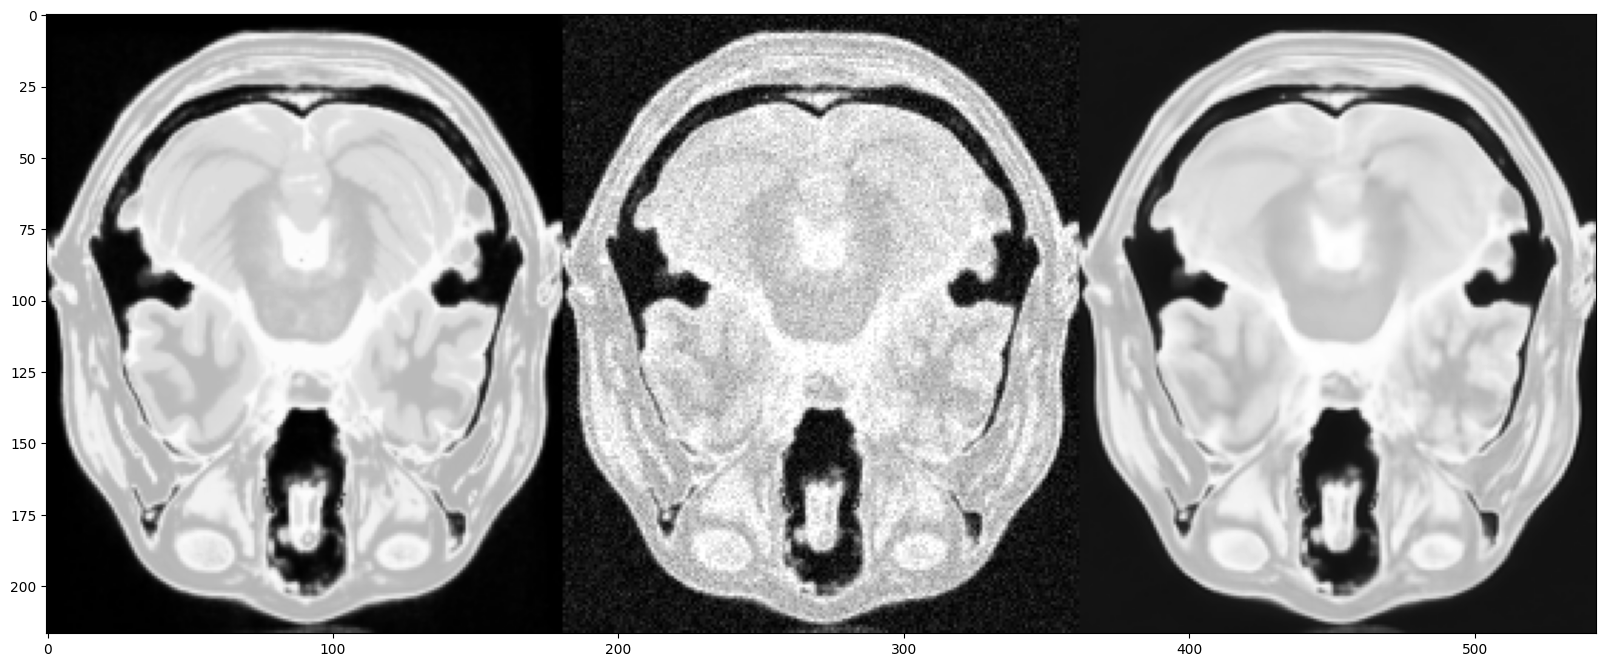

Average: psnr_cnn10    27.269741
ssim_cnn10     0.778063
dtype: float64


In [22]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd
import json

phase = "test"
sigma = 15
num_samples = 10


def make_noised_img(img, sigma=sigma):
    # Noise
    noise1 = np.random.randn(img.shape[0], img.shape[1]) * sigma
    noise2 = np.random.randn(img.shape[0], img.shape[1]) * sigma

    # Noisy Image
    # y = np.sqrt((x + noise1) * (x + noise1) + noise2 * noise2).clip(0,255).astype(np.uint8)
    return np.sqrt((img + noise1) * (img + noise1) + noise2 * noise2)


data = glob.glob(f"{dncnn_config['data_dir']}/{phase}/origin/*.npy")
print(f"Number images of sigma {sigma}: {len(data)}")

clip = True
normalize = True


def get_infor(data, lib="torch"):
    lib = torch if lib == "torch" else np
    return f"Max: {lib.max(data)} - Min: {lib.min(data)}"


metric_table = pd.DataFrame(columns=["psnr_cnn10", "ssim_cnn10"])

columns = list(metric_table.keys())

for image_path in random.sample(data, num_samples):

    metric = {"psnr": {"resnet": 0, "cnn": 0}, "ssim": {"resnet": 0, "cnn": 0}}

    origin = read_npy(image_path).astype(np.float32) / 255
    noised_im = make_noised_img(origin * 255, sigma=sigma).astype(np.float32) / 255
    # if clip:
    #     noised_im = noised_im.clip(0,255)

    origin_tensor = (
        torch.from_numpy(np.ascontiguousarray(origin)).unsqueeze(0).float().unsqueeze(0)
    )
    noised_im_tensor = (
        torch.from_numpy(np.ascontiguousarray(noised_im))
        .unsqueeze(0)
        .float()
        .unsqueeze(0)
    )
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")

    # logger.info('------------------After------------------')
    # logger.debug(f"origin_tensor: {get_infor(origin_tensor)}")
    # logger.debug(f"noised_im_tensor: {get_infor(noised_im_tensor)}")
    dncnn_pred_noise = model(noised_im_tensor.cuda())

    denoise_dncnn = dncnn_pred_noise

    denoise_dncnn = denoise_dncnn * 255

    denoise_dncnn = denoise_dncnn.clamp(0, 255)

    denoise_dncnn = (
        denoise_dncnn.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
    )

    metric["psnr"]["cnn"] = psnr((origin * 255).astype(np.uint8), denoise_dncnn)

    metric["ssim"]["cnn"] = ssim((origin * 255).astype(np.uint8), denoise_dncnn)
    row = {columns[0]: metric["psnr"]["cnn"], columns[1]: metric["ssim"]["cnn"]}
    metric_table = metric_table.append(row, ignore_index=True)
    # print(json.dumps(metric, sort_keys=True, indent=4))
    show_im(
        [
            (origin * 255).astype(np.uint8),
            (noised_im * 255).clip(0, 255).astype(np.uint8),
            denoise_dncnn,
        ]
    )

# print(metric_table)
print(f"Average: {metric_table.mean()}")